<a href="https://colab.research.google.com/github/Kunal1012481/healthcare-diabetes-risk-prediction/blob/main/Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix,classification_report
import shap
import joblib

In [ ]:
sns.set(style = 'whitegrid')
plt.rcParams['figure.figsize']=(10,5)

## **1.Load Dataset**

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/diabetes.csv')

Mounted at /content/drive


In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


**2. Quick EDA**

In [ ]:
print(df.describe(include= 'all').T)

                          count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinT

In [ ]:
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
# some medical dataset uses 0 as missing for certain columns
#columns where zero(0) is physically impossible/indicates missing

zero_as_missing = ['Glucode','BloodPressure','SkinThickness',
                   'Insulin','BMI']

for col in zero_as_missing:
  if col in df.columns:
    missing_count = (df[col]==0).sum()
    print(f'{col} zeros (likely missing):{missing_count}')


BloodPressure zeros (likely missing):35
SkinThickness zeros (likely missing):227
Insulin zeros (likely missing):374
BMI zeros (likely missing):11


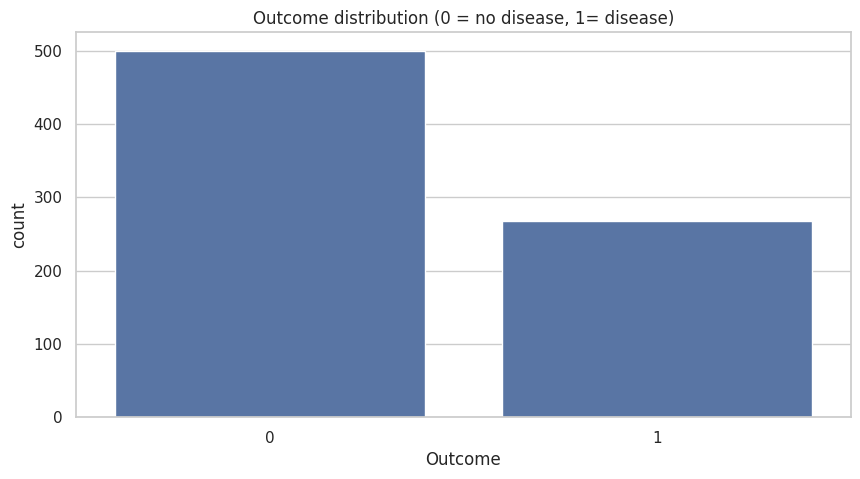

In [ ]:
#visual outcome distribution
if 'Outcome' in df.columns:
  sns.countplot(x='Outcome', data = df)
  plt.title('Outcome distribution (0 = no disease, 1= disease)')
  plt.show()

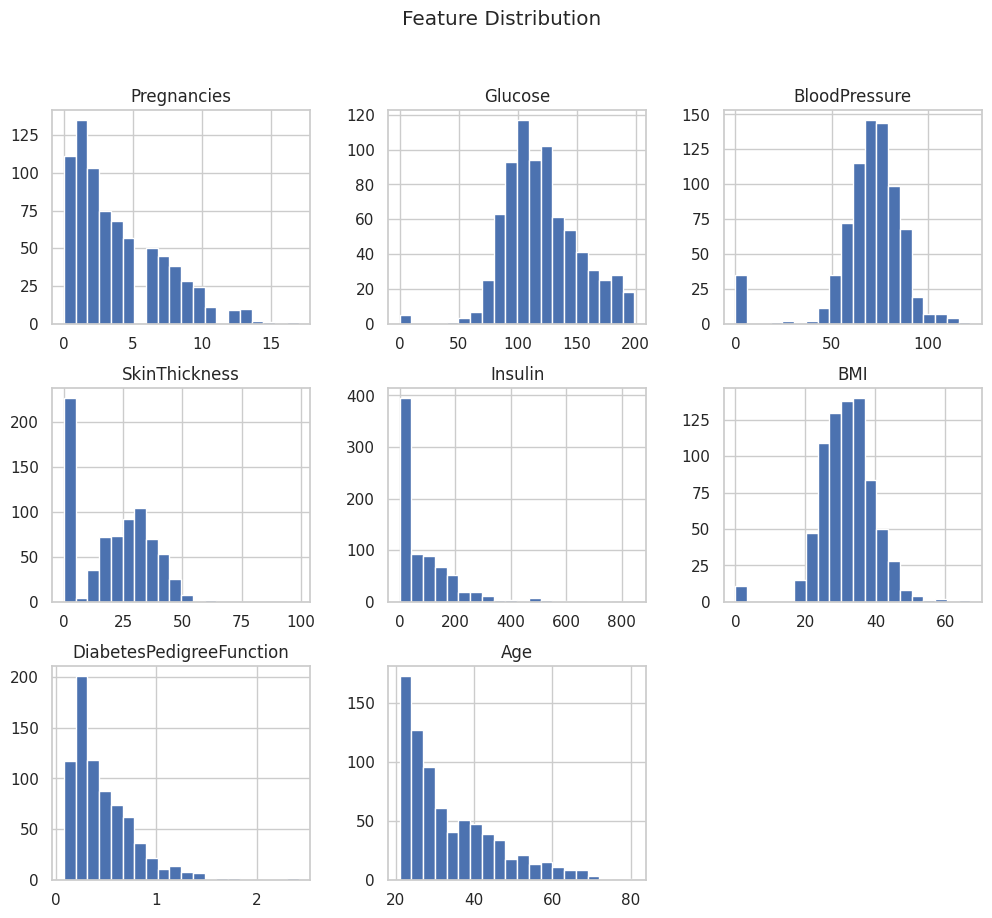

In [ ]:
#histogram for numeric features
num_cols = df.select_dtypes(include = [np.number]).columns.tolist()
num_cols.remove('Outcome') if 'Outcome' in num_cols else None

df[num_cols].hist (bins = 20, figsize =(12,10))
plt.suptitle('Feature Distribution')
plt.show()

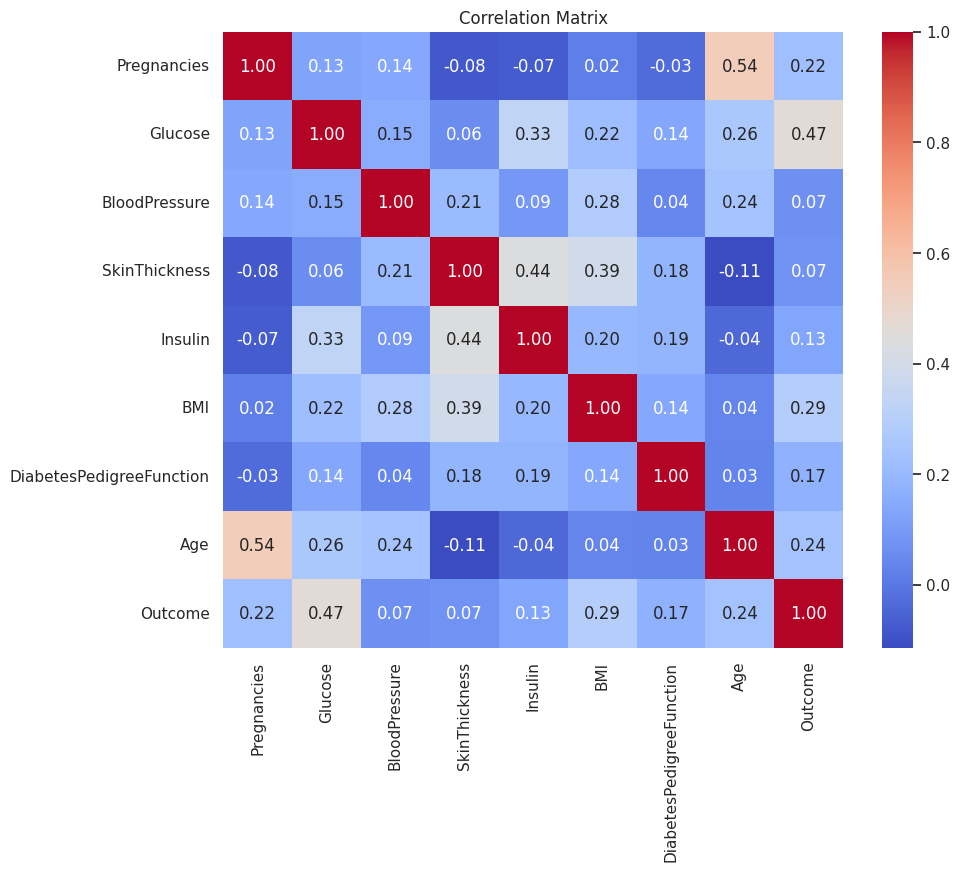

In [ ]:
#Correlation Heatmap
corr = df.corr()
plt.figure(figsize = (10,8))
sns.heatmap (corr, annot= True,fmt = '.2f', cmap ='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# 3. Data cleaning and Feature Engineering

In [ ]:
#replace zeros with NaN for columns where 0 is invalid
for col in zero_as_missing:
  if col in df.columns:
    df[col] = df[col].replace(0,np.nan)

#impute missing with median(robust for skewd medical features)
imputer = SimpleImputer(strategy = 'median')
df[num_cols]= imputer.fit_transform(df[num_cols])

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,125.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,125.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,29.0,125.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.0,125.0,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0
766,1.0,126.0,60.0,29.0,125.0,30.1,0.349,47.0,1


In [ ]:
#Example engineered features
#Age group
#BMI Category

if 'Age' in df.columns:
  bins =[0,35,45,60,120]
  labels= ['<30','30-44','45-59','60+']
  df['AgeGroup']= pd.cut(df['Age'],bins = bins, labels = labels)

if 'BMI' in df.columns:
  def bmi_cat(b):
    if b <18.5: return 'underweight'
    if b <25: return 'normal'
    if b <30: return 'overweight'
    return 'obese'

In [ ]:
df['BMI Category'] = df['BMI'].apply(bmi_cat)

In [ ]:
df['BMI Category']

,BMI Category
0,obese
1,overweight
2,normal
3,overweight
4,obese
...,...
763,obese
764,obese
765,overweight
766,obese


**4. Prepare for modeling**

In [ ]:
x=df.drop(columns = ['Outcome']) if 'Outcome' in df.columns else df.copy()
y= df['Outcome'] if 'Outcome' in df.columns else None

In [ ]:
# one hot encode categorical engineered features
x= pd.get_dummies(x, drop_first = True)

In [ ]:
#Train Test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, stratify = y,random_state = 42)

In [ ]:
#scale numeric columns
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

**4. Baseline model : Logistic Regression**

In [ ]:
lr = LogisticRegression(max_iter = 1000,random_state = 42)
lr.fit(x_train_scaled, y_train)
y_pred_lr = lr.predict(x_test_scaled)
y_prob_lr = lr.predict_proba(x_test_scaled)[: , 1]

In [ ]:
#Metrics

def print_metrics(y_true, y_pred, y_prob=None):
  print('Accuracy', round(accuracy_score(y_true,y_pred),4))
  print('Precision',round(precision_score(y_true,y_pred),4))
  print('Recall',round(recall_score(y_true,y_pred),4))
  print('F1',round(f1_score(y_true,y_pred),4))

  if y_prob is not None:
    print('ROC AUC: ',round(roc_auc_score(y_true,y_prob),4))

  print('Confusion Matrix:')
  print(confusion_matrix(y_true,y_pred))


In [ ]:
print('\n-- Logistic Regression --')
print_metrics(y_test,y_pred_lr,y_prob_lr)


-- Logistic Regression --
Accuracy 0.7273
Precision 0.625
Recall 0.5556
F1 0.5882
ROC AUC:  0.8326
Confusion Matrix:
[[82 18]
 [24 30]]


**5. Improved model: RandomForest (with simple grid search)**

In [ ]:
rf = RandomForestClassifier(random_state = 42)
params = {'n_estimators' : [100], 'max_depth': [4,6,8], 'min_samples_leaf': [5,10]}
grid = GridSearchCV(rf, params, cv = 4, scoring = 'roc_auc', n_jobs = -1)
grid.fit(x_train_scaled, y_train)
print('\n Best RF params:', grid.best_params_)
best_rf = grid.best_estimator_


 Best RF params: {'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 100}


In [ ]:
y_pred_rf = best_rf.predict(x_test_scaled)
y_prob_rf = best_rf.predict_proba(x_test_scaled)[:,1]
print('\n--- Random Forest ---')
print_metrics(y_test,y_pred_rf,y_prob_rf)


--- Random Forest ---
Accuracy 0.7338
Precision 0.6585
Recall 0.5
F1 0.5684
ROC AUC:  0.8154
Confusion Matrix:
[[86 14]
 [27 27]]


In [ ]:
#Save models & Scaler for later use
joblib.dump(lr, 'logistic_model.joblib')
joblib.dump(best_rf, 'rf_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

**6. Risk Scoring & buckets**

In [ ]:
risk_scores = pd.Series(y_prob_rf, index = x_test.index, name = 'RiskScore')
results = x_test.copy()
results['RiskScore'] = risk_scores
results['Pred'] = y_pred_rf
results['Actual'] = y_test

In [ ]:
#Create Buckets
results['RiskBucket'] = pd.cut(results['RiskScore'],bins = [0,0.2,0.5,0.7,1.0], labels = ['Low','Medium','High','Very High'])
print('\n Risk bucket count : \n', results['RiskBucket'].value_counts())


 Risk bucket count : 
 RiskBucket
Medium       57
Low          56
High         25
Very High    16
Name: count, dtype: int64


In [ ]:
#Group level insights
grouped = results.groupby('RiskBucket', observed=True).agg(
    {
        'RiskScore':['count', 'mean'],
        'Pred':'sum',
        'Actual':'sum'
    }
)
print('\n Grouped insights:', grouped)


 Grouped insights:            RiskScore           Pred Actual
               count      mean  sum    sum
RiskBucket                                
Low               56  0.093954    0      5
Medium            57  0.358322    0     22
High              25  0.606288   25     14
Very High         16  0.740940   16     13


In [ ]:
#Example cohort insight : Average Age & BMI by bucket

for col in ['Age', 'BMI']:
  if col in x_test.columns:
    print(f'\n Average {col} by RiskBucket: ')
    print(pd.concat([x_test.reset_index(drop=True),results['RiskBucket'].reset_index(drop=True)],axis=1).groupby('RiskBucket',observed=True)
    [col].mean())



 Average Age by RiskBucket: 
RiskBucket
Low          25.946429
Medium       35.473684
High         37.920000
Very High    38.687500
Name: Age, dtype: float64

 Average BMI by RiskBucket: 
RiskBucket
Low          27.467857
Medium       33.991228
High         36.864000
Very High    37.875000
Name: BMI, dtype: float64


**7. Explainability : SHAP for RandomForest**

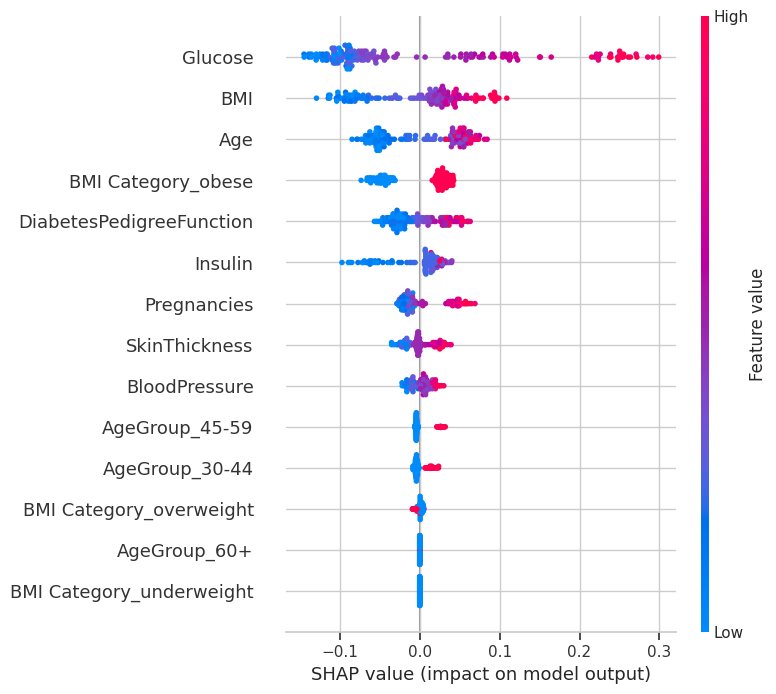

In [ ]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(x_test_scaled)

# Summary plot (global feature importance)
shap.initjs()
shap.summary_plot(shap_values[:, :, 1], x_test_scaled, feature_names = x_test.columns, show=True)

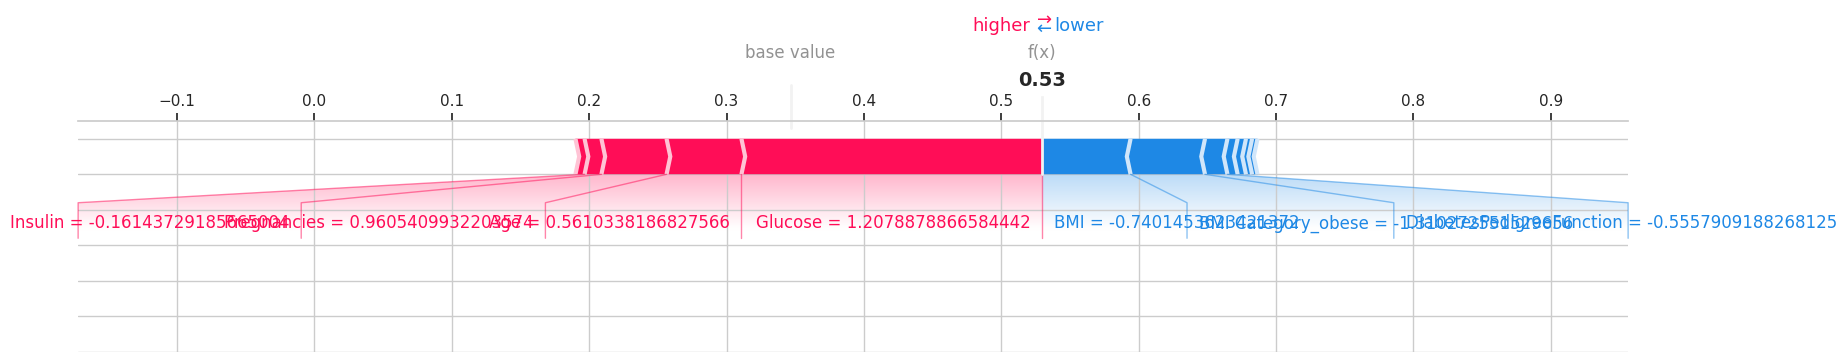

In [ ]:
#Force plot for first patient
idx = 0
if hasattr(shap,'force_plot'):
  patient_shap = shap.force_plot(explainer.expected_value[1],
   shap_values[idx, :, 1],
   x_test_scaled[idx,:],
   feature_names = x_test.columns,
   matplotlib=True
  )

**8. Simple Visualizations**

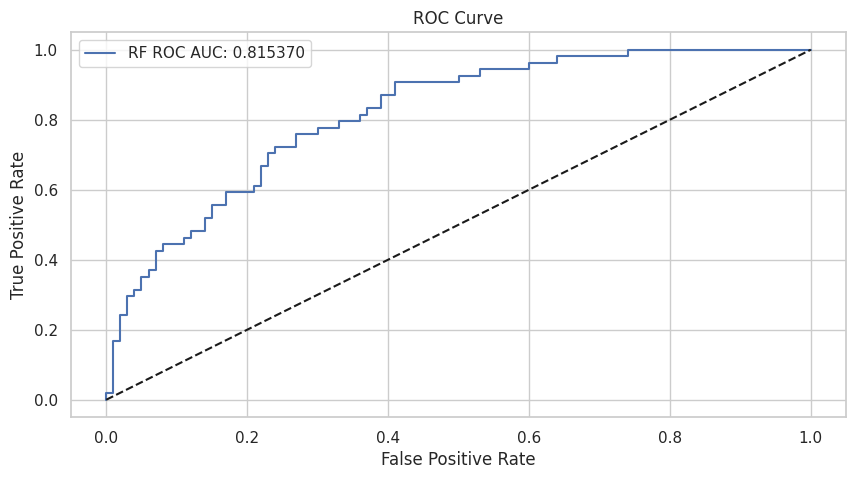

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label = f'RF ROC AUC: {roc_auc_score(y_test, y_prob_rf):3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

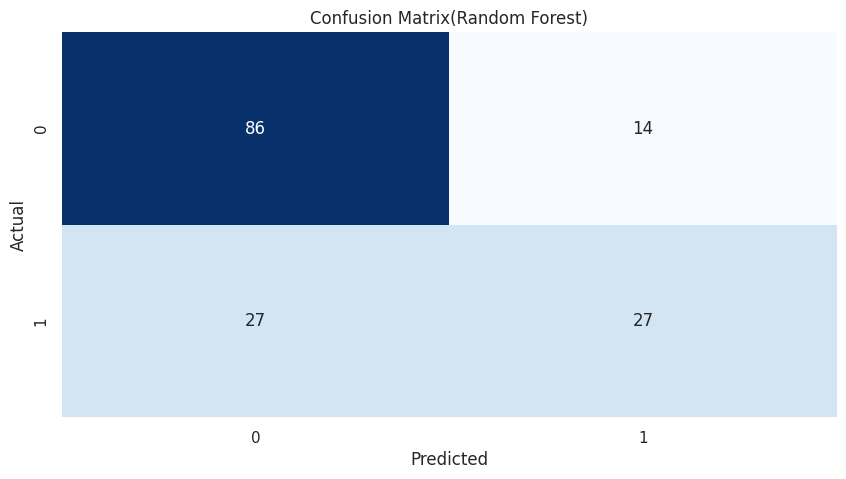

In [ ]:
# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix(Random Forest)')
plt.show()

# 9. Top insights

In [ ]:
# 1. Top risk features from SHAP
shap_importance = pd.DataFrame({
    'feature': x_test.columns,
    'mean_abs_shap': np.abs(shap_values[:, :, 1]).mean(axis=0)
}).sort_values(by = 'mean_abs_shap', ascending = False)

print('''
Top risk features from SHAP:''',shap_importance.head(10))


Top risk features from SHAP:                      feature  mean_abs_shap
1                    Glucose       0.111850
5                        BMI       0.051721
7                        Age       0.048485
11        BMI Category_obese       0.036420
6   DiabetesPedigreeFunction       0.027485
4                    Insulin       0.024888
0                Pregnancies       0.023344
3              SkinThickness       0.013691
2              BloodPressure       0.009879
9             AgeGroup_45-59       0.007097


In [ ]:
# 2. Proportion of positives by Riskbucket
pos_by_bucket = results.groupby('RiskBucket', observed= True)['Actual'].mean()
print('\n Proportion of positives by RiskBucket:')
print(pos_by_bucket)


 Proportion of positives by RiskBucket:
RiskBucket
Low          0.089286
Medium       0.385965
High         0.560000
Very High    0.812500
Name: Actual, dtype: float64
